# NLP Answers

- **Answer Set**: No. 05
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Introduction

In this problem, we are going to use **ParsBERT** pre-trained model for **Text Classification** task on **Persica** dataset.  
Then we will compare the reported metrics to previously trained models in `exercise 4`

In the first step, we will import some useful libraries.

In [1]:
import warnings

import math as math
import hazm as hazm

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import sklearn.svm as sksvm
import sklearn.tree as sktree
import sklearn.ensemble as skensemble
import sklearn.decomposition as skdecompose

import sklearn.base as skbase
import sklearn.utils as skutils
import sklearn.metrics as skmetrics
import sklearn.pipeline as skpipeline
import sklearn.preprocessing as skprocessing
import sklearn.model_selection as skselection
import sklearn.feature_extraction.text as sktext

warnings.filterwarnings("ignore", category=UserWarning)
sk.set_config(display="diagram")

---

## Loading

First of all, we must load the **Persica** dataset and then shuffle the records.

In [64]:
from datasets import Dataset

corpus = hazm.PersicaReader(csv_file="../lib/persica.csv")

data_frame = pd.DataFrame(corpus.docs())
data_frame = skutils.shuffle(data_frame)

labels = list(sorted(data_frame["category2"].unique()))
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}
data_frame["label"] = data_frame["category2"].apply(lambda x: label2id[x])

data_features = data_frame.filter(["text"], axis=1).to_numpy().flatten()
data_labels = data_frame.filter(["category2"], axis=1).to_numpy().flatten()

dataset = Dataset.from_pandas(data_frame)

### Analyse

In this section, we are going to visualize the data and analyse and compute some useful parameters that will be used in the `Cleaning` and `Transformation` steps.

Minimum tokens count in sentences: 1
Maximum tokens count in sentences: 1218


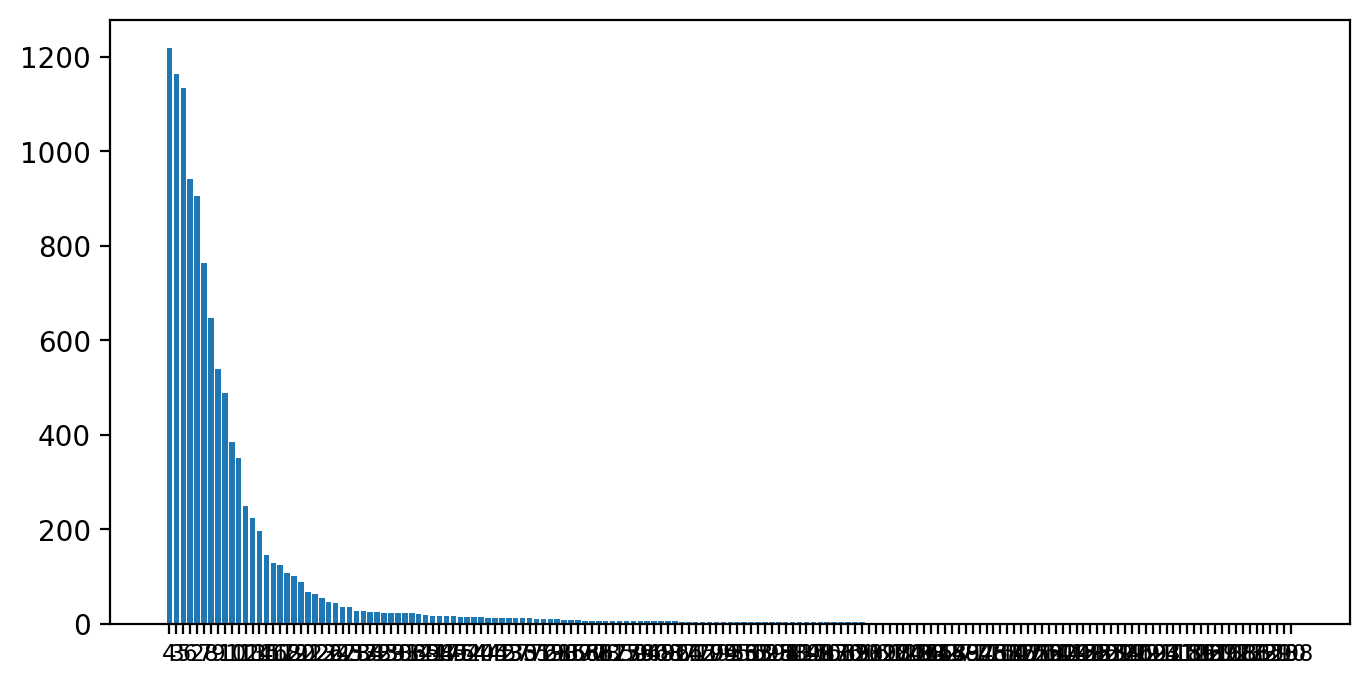

In [ ]:
data_frame["tokens"] = data_frame["text"].apply(lambda text : hazm.sent_tokenize(text))
data_frame["tokens_count"] = data_frame["tokens"].apply(lambda tokens : len(tokens))

tokens_min = data_frame["tokens_count"].value_counts().min()
tokens_max = data_frame["tokens_count"].value_counts().max()

print(f"Minimum tokens count in sentences: {tokens_min}")
print(f"Maximum tokens count in sentences: {tokens_max}")

df = pd.Series(data_frame["tokens_count"].value_counts())

plt.figure(figsize=(8, 4), dpi=200)
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.show()

As we can see, most of the sentences word counts are in range between `0 and 200`.

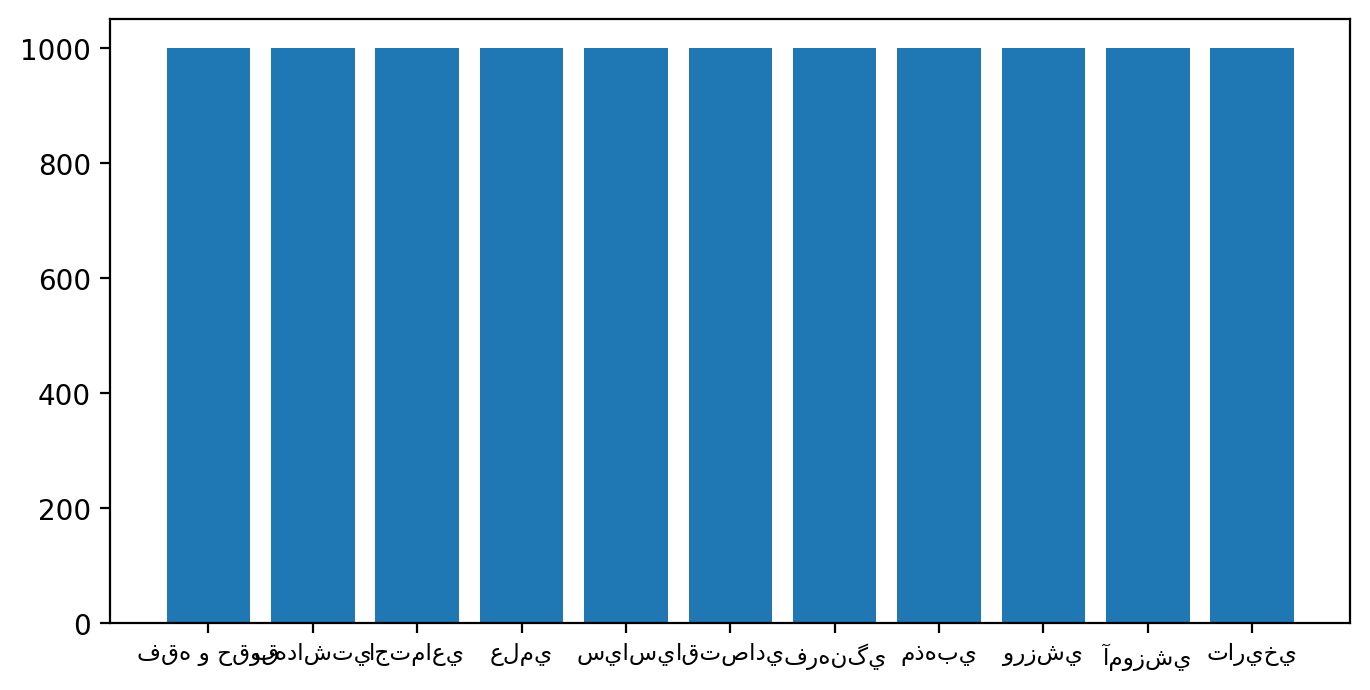

In [ ]:
categories_min = data_frame["category2"].value_counts().min()
categories_max = data_frame["category2"].value_counts().max()

df = pd.Series(data_frame["category2"].value_counts())

plt.figure(figsize=(8, 4), dpi=200)
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.show()

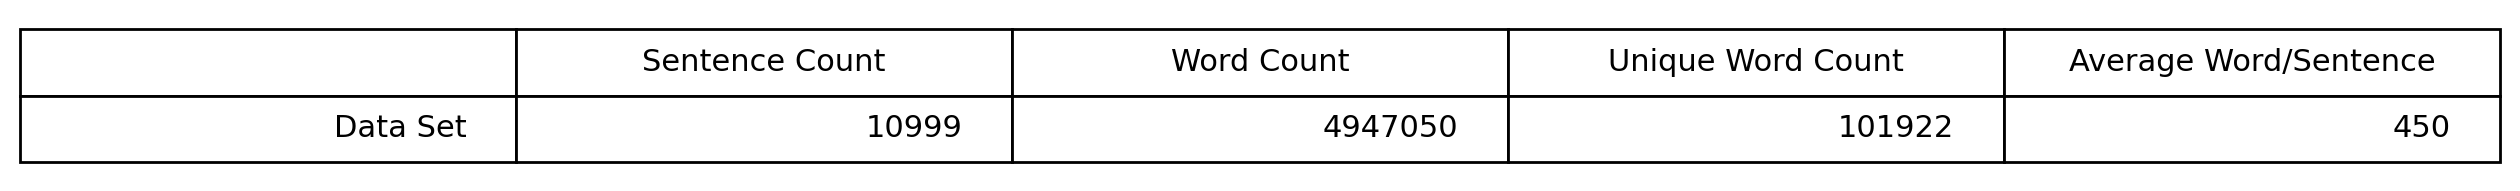

In [29]:
data_words = hazm.word_tokenize('. '.join(data_features))

plt.figure(figsize=(8, 1), dpi=200)
table = plt.table(cellText=[
    [
        "Data Set",
        len(data_features),
        len(data_words),
        len(set(data_words)),
        round(len(data_words) / len(data_features))
    ]
], colLabels=["", "Sentence Count", "Word Count", "Unique Word Count", "Average Word/Sentence"], loc="center")
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 2)
plt.axis("off")
plt.show()

### Cleaning

---

## Preprocessing

In [30]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [69]:
# train_x = tokenizer(list(data_features), return_tensors='tf', truncation=True, padding=True, max_length=1200)
train_x = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True, max_length=512), batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

In [70]:
train_xx = train_x.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    batch_size=8,
)

---

## Splitting

In [19]:
data_features = data_frame.filter(["text"], axis=1).to_numpy().flatten()
data_labels = data_frame.filter(["category2"], axis=1).to_numpy().flatten()

data_labels = skprocessing.LabelEncoder().fit(data_labels).transform(data_labels)

train_features, test_features, train_labels, test_labels = skselection.train_test_split(
    data_features, 
    data_labels, 
    test_size=0.2, 
    random_state=313
)

---

## Training

In [67]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFAutoModelForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
config = BertConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
config.num_labels = 8

model = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", config)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
r = model.fit(train_xx, epochs=10)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\kernelbase.py", line 369, in dispatch_shell
      await result
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\KoLiBer\AppData\Local\Temp\ipykernel_14984\3732789637.py", line 1, in <cell line: 1>
      r = model.fit(train_xx, epochs=10)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1432, in train_step
      loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\KoLiBer\Documents\Workspace\nlpexercises\.venv\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 8 which is outside the valid range of [0, 2).  Label values: 8 8 8 1 3 5 6 2
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_148437]

---

## Testing

---